## Jeffrey Elkner

### Problem: Point Pattern Descriptors

The tracking data for Hurricane Bill (2009) is given in the attached package, suitable for ArcGIS. One folder contains the best track data via SHIPS database (SHIPS_2009Bill) and the other is a track forecasting data from NHC (National Hurricane Center) for Hurricane Bill at August 17 at 1500 (2009BillForecasting17_1500) for forecasting tracks in 12 hours interval for 3 days and 24 hour interval beyond that for up to 5 days.  Using the SHIPS data, please

> a. Calculate the Standard Distance and output the SD value (3 points)

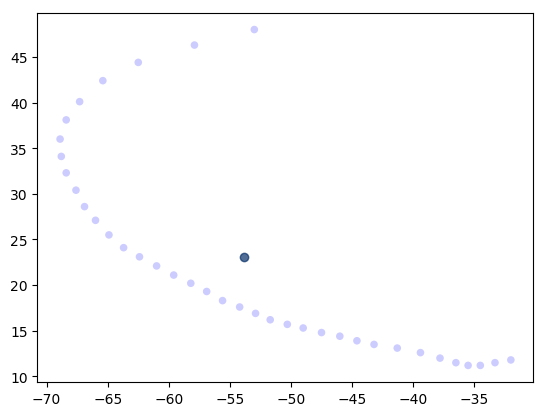

In [1]:
# SOLUTION
# http://webspace.ship.edu/pgmarr/Geo441/Examples/Standard%20Distance.pdf
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import thinkstats2 as ts
import thinkplot as tp
import shapefile
from ggs560.ggs560_tools import mean_center, standard_distance

def shape2dataframe(path2shape):
    sf = shapefile.Reader(path2shape)

    #grab the shapefile's field names (omit the first psuedo field)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write the records into a dataframe
    shpdf = pd.DataFrame(columns=fields, data=records)

    #add the coordinate data to a column called "coords"
    shpdf = shpdf.assign(coords=shps)
    
    return shpdf

df = shape2dataframe('Data/SHIPS_2009Bill/SHIPS_2009Bill')

df.coords[0][0][-1]
len(df.coords)
df.coords[36]

xs = [point[0][0] for point in df.coords]
ys = [point[0][1] for point in df.coords]
cx, cy = mean_center(list(zip(xs, ys)))
sd = standard_distance(xs, ys)

tp.Scatter(xs, ys)
tp.Plot(cx, cy, 'o')
tp.Show()

> b. Calculate the deviational ellipse (Directional Distribution) and output the rotation angle, the deviations along the major axis and minor axis. (3 points)

> c. Show that the total circular variance is conserved before and after the rotation or the conservation relationship between the standard distance and the semi-major and semi-minor axes of the deviational ellipse. (3 points)

> d. Use the forecasting data to repeat the Directional Distribution analysis. (1 point)

> e. (Optional/open-end) Please compare the results of the directional distribution from the SHIPS data and from the forecasting data and discuss the possibility for using the forecasting data to cluster tracks of tropical cyclones. (xx points)

In [2]:
df2 = shape2dataframe('Data/BillForcast/2009Bill_Forecasting17_1500')

#### Notes for additional information:
0. The SHIPS data files can be found at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/. One of the data files for the period 1989-2009 hurricane season can be downloaded at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/2010/lsdiaga_1982_2009_rean_biascorr_sat.dat, and the corresponding document file for this data file is also available at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/2009/SHIPS_predictor_file_2009.doc. The original data are in ASCII but the data are hard to handle.

0. The forecasting data can be found at http://www.nhc.noaa.gov/data/. More information including the metadata information can also be found in the same site. 